### Black-Litterman Model for Portfolio Optimization

⏳ Running Black-Litterman optimization...
EF failed at index 30, using equal weights. Error: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


EF failed at index 240, using equal weights. Error: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.
EF failed at index 1451, using equal weights. Error: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.
EF failed at index 1603, using equal weights. Error: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.
EF failed at index 1641, using equal weights. Error: Adding constraints to an already solved problem might have unintended consequences. A new instance should be created for the new set of constraints.
✅ Completed in 16.76 seconds

📊 Black-Litterman Portfolio Performance (Sharpe + Weights)
Sharpe Ratio: 2.3136
Annualized Return: 8.9409%
Annualized Volatility: 3.7322%
Max Drawdown: 23.4866%
Av

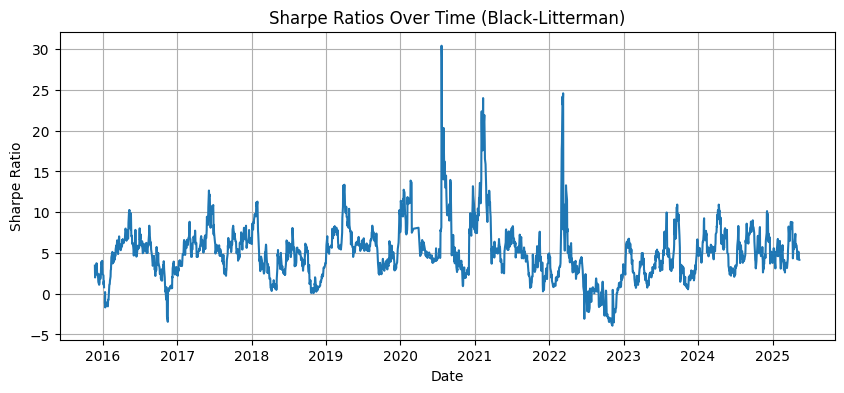

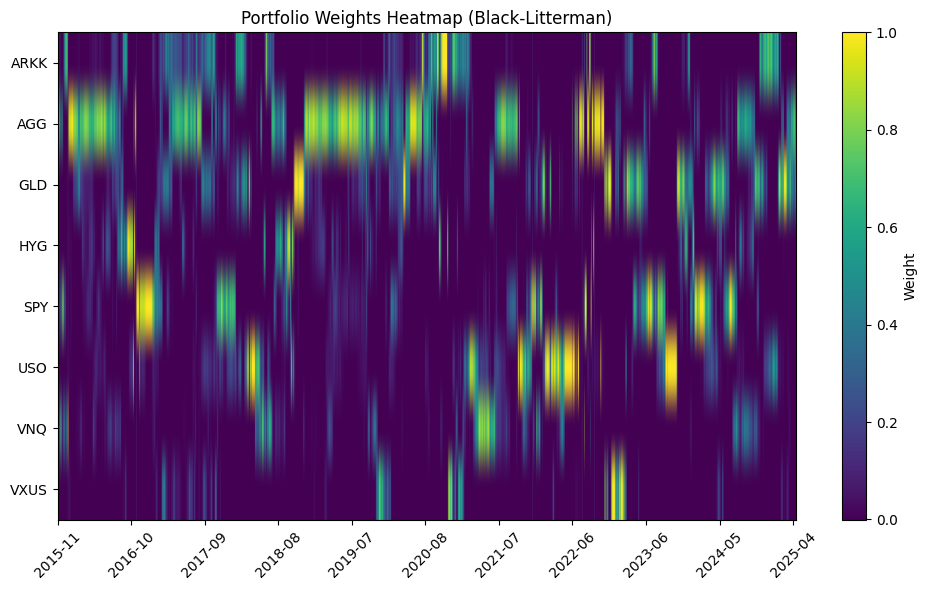

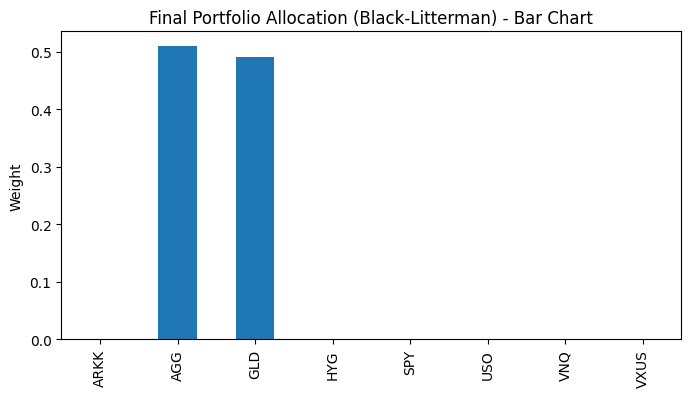

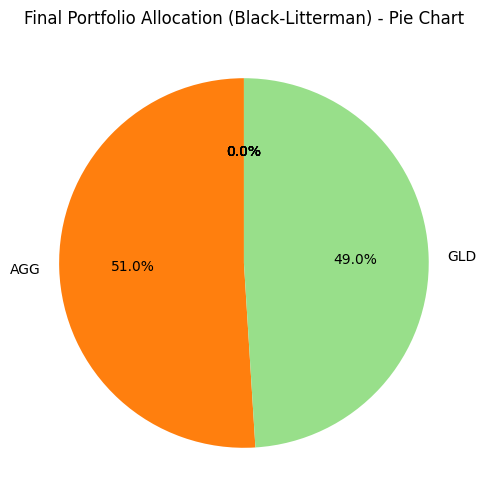

📂 Results saved: bl_generated_weights_timeseries.csv & bl_sharpe_timeseries.csv


In [4]:
# === 📈 Black-Litterman Portfolio Optimization (Sharpe + Weights Results) ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

# --- 1. Load and prepare raw ETF data ---
csv_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
data = pd.read_csv(csv_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']

# Pivot to wide format for prices
prices = data.pivot(index='Date', columns='Ticker', values='Close')
prices = prices[assets].dropna()

# --- 2. Black-Litterman Target Generation ---
def generate_bl_results(prices_df, window=60, lookahead=20, tau=0.025):
    weights_list, sharpe_list, dates = [], [], []
    portfolio_returns = []
    for start in range(len(prices_df) - window - lookahead):
        window_prices = prices_df.iloc[start:start+window]
        future_prices = prices_df.iloc[start+window:start+window+lookahead]
        future_returns = future_prices.pct_change().dropna()

        cov = risk_models.sample_cov(window_prices)
        mu = expected_returns.mean_historical_return(window_prices)

        market_caps = np.ones(len(prices_df.columns))
        bl = BlackLittermanModel(
            cov_matrix=cov,
            pi=mu,
            market_caps=market_caps,
            tau=tau,
            P=np.empty((0, len(prices_df.columns))),
            Q=np.empty((0,))
        )
        bl_mu = bl.bl_returns()
        bl_cov = bl.bl_cov()

        try:
            ef = EfficientFrontier(bl_mu, bl_cov)
            try:
                weights_dict = ef.max_sharpe(risk_free_rate=0.0)
            except Exception:
                weights_dict = ef.min_volatility()
            w_arr = np.array([weights_dict.get(col, 0.0) for col in prices_df.columns])
            ret, vol, sharpe = ef.portfolio_performance()
        except Exception as e:
            print(f"EF failed at index {start}, using equal weights. Error: {e}")
            w_arr = np.ones(len(prices_df.columns)) / len(prices_df.columns)
            sharpe = np.nan

        weights_list.append(w_arr)
        sharpe_list.append(sharpe)
        dates.append(prices_df.index[start+window])

        # realized portfolio return for evaluation
        if not future_returns.empty:
            realized = (future_returns.values @ w_arr).mean()
            portfolio_returns.append(realized)
    return (
        np.array(weights_list),
        np.array(sharpe_list),
        pd.DatetimeIndex(dates),
        np.array(portfolio_returns)
    )

print("⏳ Running Black-Litterman optimization...")
start = time.time()
weights_target, sharpe_target, date_index, portfolio_returns = generate_bl_results(prices)
end = time.time()

print(f"✅ Completed in {end-start:.2f} seconds")

# --- 3. Standardize Sharpe ratios ---
scaler = StandardScaler()
sharpe_scaled = scaler.fit_transform(np.nan_to_num(sharpe_target).reshape(-1,1)).flatten()

# --- 4. Evaluation Metrics ---
# Compute realized portfolio metrics from realized returns
returns_series = pd.Series(portfolio_returns).dropna()
cum_values = (1 + returns_series).cumprod()
peak = cum_values.cummax()
drawdown = (peak - cum_values) / peak
max_drawdown = drawdown.max() if not drawdown.empty else np.nan
annualized_return = (cum_values.iloc[-1]) ** (252/len(returns_series)) - 1 if len(returns_series) > 0 else np.nan
annualized_volatility = returns_series.std() * np.sqrt(252) if len(returns_series) > 0 else np.nan
sharpe_ratio = returns_series.mean() * 252 / (annualized_volatility + 1e-8) if annualized_volatility > 0 else np.nan

print("\n📊 Black-Litterman Portfolio Performance (Sharpe + Weights)")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Return: {annualized_return:.4%}")
print(f"Annualized Volatility: {annualized_volatility:.4%}")
print(f"Max Drawdown: {max_drawdown:.4%}")

# Turnover (average weight change)
if weights_target.shape[0] > 1:
    turnover = np.mean(np.sum(np.abs(np.diff(weights_target, axis=0)), axis=1))
else:
    turnover = np.nan
print(f"Average Turnover: {turnover:.4f}")

# --- 5. Visualization ---
plt.figure(figsize=(10,4))
plt.plot(date_index, sharpe_target)
plt.title("Sharpe Ratios Over Time (Black-Litterman)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(weights_target.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Weight')
plt.yticks(range(len(assets)), assets)
if len(date_index) > 1:
    step = max(1, len(date_index)//10)
    xticks_pos = np.arange(0, len(date_index), step)
    xtick_labels = [date.strftime('%Y-%m') for date in date_index[::step]]
    plt.xticks(xticks_pos, xtick_labels, rotation=45)
plt.title("Portfolio Weights Heatmap (Black-Litterman)")
plt.tight_layout()
plt.show()

# Final portfolio weights (last period)
final_weights = pd.Series(weights_target[-1], index=assets)
plt.figure(figsize=(8,4))
final_weights.plot(kind='bar')
plt.title("Final Portfolio Allocation (Black-Litterman) - Bar Chart")
plt.ylabel("Weight")
plt.show()

# Pie chart of allocations
plt.figure(figsize=(6,6))
final_weights.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20')
plt.ylabel("")
plt.title("Final Portfolio Allocation (Black-Litterman) - Pie Chart")
plt.show()

# Save results as DataFrames
weights_df = pd.DataFrame(weights_target, index=date_index, columns=assets)
weights_df.to_csv("bl_generated_weights_timeseries.csv")
pd.Series(sharpe_target, index=date_index, name="Sharpe").to_csv("bl_sharpe_timeseries.csv")
print("📂 Results saved: bl_generated_weights_timeseries.csv & bl_sharpe_timeseries.csv")


In [1]:
# === 📈 Black-Litterman Portfolio Optimization (Stable Version) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns, market_implied_risk_aversion
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt.risk_models import CovarianceShrinkage


# --- 1. Load and prepare raw ETF data ---
csv_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'

data = pd.read_csv(csv_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']

# Pivot to wide format for prices
prices = data.pivot(index='Date', columns='Ticker', values='Close')
prices = prices[assets].dropna()


# --- 2. Manual Market Caps (Assets Under Management / Market Value, USD) ---
# These values can be updated from fund providers or Bloomberg/Morningstar
manual_caps = {
    "ARKK": 7e9,    # ARK Innovation ETF
    "AGG": 100e9,   # iShares Core US Aggregate Bond ETF
    "GLD": 60e9,    # SPDR Gold Trust
    "HYG": 18e9,    # iShares iBoxx High Yield Corp Bond
    "SPY": 450e9,   # SPDR S&P 500 ETF
    "USO": 1.5e9,   # US Oil Fund
    "VNQ": 30e9,    # Vanguard Real Estate ETF
    "VXUS": 60e9    # Vanguard Total International Stock ETF
}
market_caps = np.array([manual_caps[t] for t in assets])


# --- 3. Utility functions ---
def make_psd(matrix, eps=1e-8):
    """Force matrix to be symmetric PSD by clipping eigenvalues."""
    M = np.asarray((matrix + matrix.T) / 2.0)
    vals, vecs = np.linalg.eigh(M)
    vals_clipped = np.clip(vals, eps, None)
    M_psd = (vecs * vals_clipped) @ vecs.T
    return pd.DataFrame(M_psd, index=getattr(matrix, "index", None), columns=getattr(matrix, "columns", None))


def generate_bl_results_stable(prices_df, market_caps, window=60, lookahead=20, tau=0.05, long_only=True):
    """Robust rolling Black-Litterman generator with shrinkage, PSD fix, and safe EF handling."""
    weights_list, sharpe_list, dates = [], [], []
    portfolio_returns = []

    tickers = list(prices_df.columns)

    for start in range(len(prices_df) - window - lookahead):
        window_prices = prices_df.iloc[start:start+window]
        future_prices = prices_df.iloc[start+window:start+window+lookahead]
        future_returns = future_prices.pct_change().dropna()

        # --- 1) Covariance ---
        try:
            cov_shrinker = CovarianceShrinkage(window_prices)
            cov = cov_shrinker.ledoit_wolf()
        except Exception as e:
            print(f"⚠️ Covariance shrinkage failed at {start}: {e}. Using sample_cov.")
            cov = risk_models.sample_cov(window_prices)
        cov = make_psd(cov, eps=1e-10)

        # --- 2) Equilibrium prior ---
        delta = market_implied_risk_aversion(window_prices.pct_change().dropna())
        market_weights = pd.Series(market_caps / market_caps.sum(), index=cov.columns)
        try:
            pi = market_implied_prior_returns(market_weights, delta, cov)
        except Exception as e:
            print(f"⚠️ Prior returns failed at {start}: {e}. Using hist mean.")
            pi = pd.Series(window_prices.pct_change().mean(), index=cov.columns)

        # --- 3) Example view: ARKK expected to outperform AGG by 2% ---
        P = np.zeros((1, len(tickers)))
        P[0, tickers.index("ARKK")] = 1
        P[0, tickers.index("AGG")] = -1
        Q = np.array([0.02])

        # --- 4) Posterior returns ---
        try:
            bl = BlackLittermanModel(cov_matrix=cov, pi=pi, P=P, Q=Q, tau=tau, market_caps=market_caps)
            bl_mu = bl.bl_returns()
            bl_cov = make_psd(bl.bl_cov(), eps=1e-10)
        except Exception as e:
            print(f"⚠️ BL blending failed at {start}: {e}. Using priors.")
            bl_mu, bl_cov = pi, cov

        # --- 5) Optimize ---
        try:
            if long_only:
                ef = EfficientFrontier(bl_mu, bl_cov, weight_bounds=(0, 1))
            else:
                ef = EfficientFrontier(bl_mu, bl_cov)
            try:
                weights_dict = ef.max_sharpe(risk_free_rate=0.0)
                ret, vol, sharpe = ef.portfolio_performance()
            except Exception as e_max:
                print(f"⚠️ max_sharpe failed at {start}: {e_max}. Trying min_volatility.")
                if long_only:
                    ef2 = EfficientFrontier(bl_mu, bl_cov, weight_bounds=(0, 1))
                else:
                    ef2 = EfficientFrontier(bl_mu, bl_cov)
                weights_dict = ef2.min_volatility()
                ret, vol, sharpe = ef2.portfolio_performance()

            w_arr = np.array([weights_dict.get(t, 0.0) for t in tickers])
        except Exception as e:
            print(f"⚠️ Optimization failed at {start}: {e}. Equal weights fallback.")
            w_arr = np.ones(len(tickers)) / len(tickers)
            sharpe = np.nan

        weights_list.append(w_arr)
        sharpe_list.append(sharpe)
        dates.append(prices_df.index[start+window])

        if not future_returns.empty:
            realized = (future_returns.values @ w_arr).mean()
            portfolio_returns.append(realized)

    return (
        np.array(weights_list),
        np.array(sharpe_list),
        pd.DatetimeIndex(dates),
        np.array(portfolio_returns)
    )


# --- 4. Run the model ---
print("⏳ Running Conventional Black-Litterman optimization...")
start = time.time()
weights_target, sharpe_target, date_index, portfolio_returns = generate_bl_results_stable(prices, market_caps)
end = time.time()
print(f"✅ Completed in {end-start:.2f} seconds")


# --- 5. Evaluation Metrics ---
scaler = StandardScaler()
sharpe_scaled = scaler.fit_transform(np.nan_to_num(sharpe_target).reshape(-1,1)).flatten()

returns_series = pd.Series(portfolio_returns).dropna()
cum_values = (1 + returns_series).cumprod()
peak = cum_values.cummax()
drawdown = (peak - cum_values) / peak
max_drawdown = drawdown.max() if not drawdown.empty else np.nan
annualized_return = (cum_values.iloc[-1]) ** (252/len(returns_series)) - 1 if len(returns_series) > 0 else np.nan
annualized_volatility = returns_series.std() * np.sqrt(252) if len(returns_series) > 0 else np.nan
sharpe_ratio = returns_series.mean() * 252 / (annualized_volatility + 1e-8) if annualized_volatility > 0 else np.nan

print("\n📊 Black-Litterman Portfolio Performance (Sharpe + Weights)")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Return: {annualized_return:.4%}")
print(f"Annualized Volatility: {annualized_volatility:.4%}")
print(f"Max Drawdown: {max_drawdown:.4%}")


# --- 6. Turnover ---
if weights_target.shape[0] > 1:
    turnover = np.mean(np.sum(np.abs(np.diff(weights_target, axis=0)), axis=1))
else:
    turnover = np.nan
print(f"Average Turnover: {turnover:.4f}")


# --- 8. Save results ---
weights_df = pd.DataFrame(weights_target, index=date_index, columns=assets)
weights_df.to_csv("bl_generated_weights_timeseries.csv")
pd.Series(sharpe_target, index=date_index, name="Sharpe").to_csv("bl_sharpe_timeseries.csv")
print("📂 Results saved: bl_generated_weights_timeseries.csv & bl_sharpe_timeseries.csv")


⏳ Running Conventional Black-Litterman optimization...


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 0: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 17: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 18: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 19: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 52: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 53: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 54: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 70: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 71: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 72: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 88: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 89: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 90: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 103: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 104: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 105: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 121: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 122: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 123: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 139: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 140: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 141: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 157: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 158: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 159: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((a

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 172: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 173: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 174: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 190: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 191: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 192: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((a

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 208: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 209: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 210: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 226: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 227: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 228: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 241: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 242: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 243: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 259: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 260: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 261: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 277: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 278: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 279: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 295: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 296: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 297: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 310: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 311: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 312: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 328: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 329: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 330: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 345: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 346: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 347: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 363: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 364: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 365: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 378: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 379: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 380: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 396: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 397: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 398: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 414: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 415: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 416: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 432: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 433: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 434: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 447: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 448: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 449: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 465: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 466: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 467: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 483: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 484: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 485: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 498: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 499: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 500: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 516: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 517: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 518: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 533: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 534: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 535: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 551: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 552: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 553: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 566: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 567: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 568: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 583: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 584: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 585: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 601: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 602: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 603: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 616: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 617: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 618: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 634: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 635: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 636: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 652: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 653: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 654: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 667: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 668: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 669: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 685: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 686: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 687: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 703: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 704: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 705: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 718: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 719: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 720: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 736: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 737: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 738: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 753: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 754: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 755: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 768: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 769: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 770: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 786: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 787: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 788: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 804: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 805: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 806: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 819: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 820: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 821: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 837: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 838: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 839: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 855: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 856: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 857: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 870: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 871: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 872: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 888: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 889: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 890: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 906: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 907: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 908: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 921: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 922: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 923: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 939: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 940: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 941: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 956: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 957: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 958: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 971: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 972: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 973: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 989: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 990: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 991: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem see

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1007: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1008: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1009: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1022: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1023: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1024: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdim

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1040: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1041: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1042: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1058: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1059: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1060: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1073: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1074: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1075: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1091: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1092: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1093: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1106: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1107: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1108: 4. Trying min_volatility.


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1155: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1156: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1157: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1173: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1174: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1175: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1191: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1192: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1193: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1206: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1207: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1208: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1224: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1225: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1226: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1242: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1243: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1244: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1260: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1261: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1262: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1275: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1276: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1277: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1293: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1294: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1295: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1325: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1326: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1327: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1344: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1345: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1346: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1361: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1362: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1363: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1379: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1380: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1381: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1395: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1396: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1397: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1412: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1413: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1414: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1430: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1431: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1432: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1445: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1446: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1447: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((a

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1463: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1464: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1465: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1478: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1479: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1480: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1495: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1496: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1497: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1513: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1514: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1515: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1528: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1529: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1530: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1546: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1547: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1548: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1562: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1563: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1564: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1580: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1581: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1582: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1607: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1608: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1609: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1625: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1626: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1627: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1643: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1644: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1645: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1659: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1660: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1661: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1678: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1679: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1680: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1693: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1694: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1695: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1710: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1711: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1712: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1726: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1727: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1728: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return um

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1744: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1745: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1746: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1759: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1760: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1761: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1777: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1778: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1779: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1792: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1793: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1794: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1810: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1811: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1812: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1828: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1829: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1830: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1845: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1846: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1847: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1860: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1861: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1862: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1878: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1879: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1880: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1893: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1894: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1895: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1993: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1994: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 1995: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2012: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2013: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2014: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2030: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2031: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2032: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2048: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2049: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2050: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2066: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2067: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2068: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2098: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2099: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2100: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2162: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2163: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2164: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2181: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2182: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2183: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2200: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2201: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2202: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dt

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2218: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2219: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
⚠️ max_sharpe failed at 2220: 4. Trying min_volatility.
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem 

/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2

✅ Completed in 27.61 seconds

📊 Black-Litterman Portfolio Performance (Sharpe + Weights)
Sharpe Ratio: 3.1468
Annualized Return: 8.7637%
Annualized Volatility: 2.6815%
Max Drawdown: 18.5064%
Average Turnover: 0.0468
📂 Results saved: bl_generated_weights_timeseries.csv & bl_sharpe_timeseries.csv


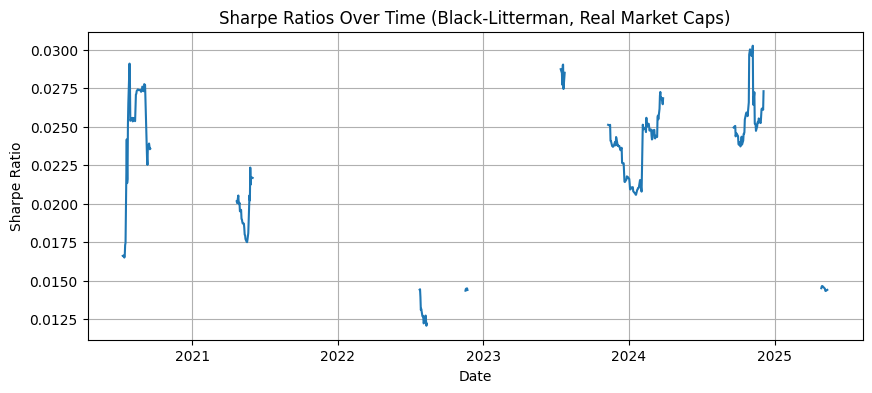

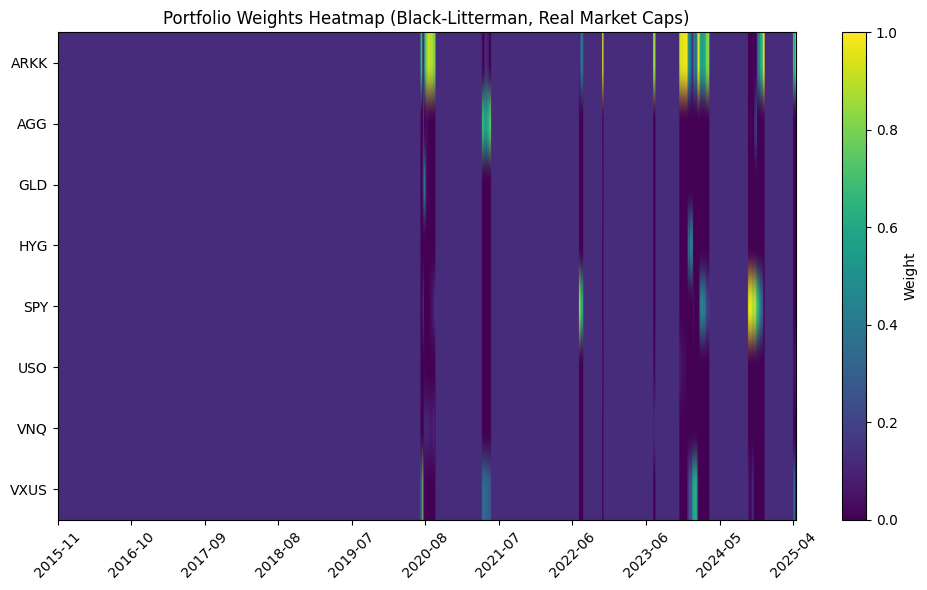

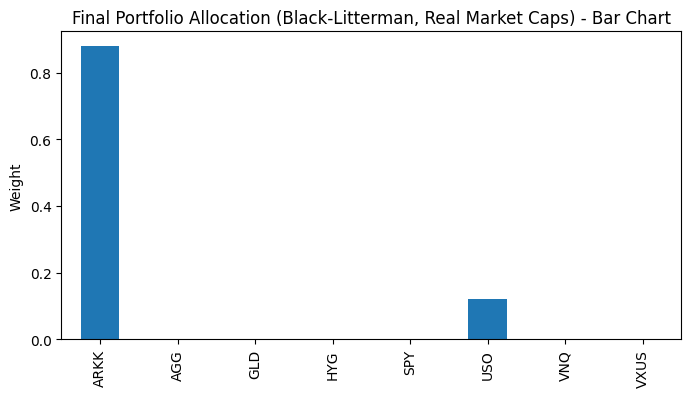

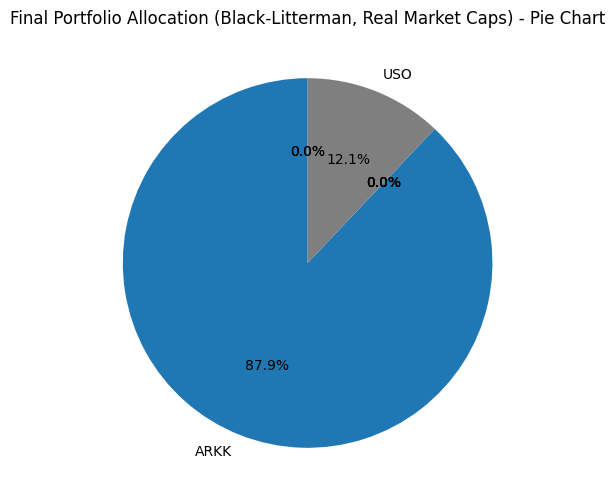

In [11]:
# --- 7. Visualization ---
plt.figure(figsize=(10,4))
plt.plot(date_index, sharpe_target)
plt.title("Sharpe Ratios Over Time (Black-Litterman)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(weights_target.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Weight')
plt.yticks(range(len(assets)), assets)
if len(date_index) > 1:
    step = max(1, len(date_index)//10)
    xticks_pos = np.arange(0, len(date_index), step)
    xtick_labels = [date.strftime('%Y-%m') for date in date_index[::step]]
    plt.xticks(xticks_pos, xtick_labels, rotation=45)
plt.title("Portfolio Weights Heatmap (Black-Litterman)")
plt.tight_layout()
plt.show()

final_weights = pd.Series(weights_target[-1], index=assets)
plt.figure(figsize=(8,4))
final_weights.plot(kind='bar')
plt.title("Final Portfolio Allocation (Black-Litterman) - Bar Chart")
plt.ylabel("Weight")
plt.show()

plt.figure(figsize=(6,6))
final_weights.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20')
plt.ylabel("")
plt.title("Final Portfolio Allocation (Black-Litterman) - Pie Chart")
plt.show()

In [6]:
first_name = 'Lucielle'
surname = ' Hushie'

print( first_name + ' ' + surname)

Lucielle  Hushie


In [12]:
from datetime import date

input = date.today()
print("Today's date:", input)

Today's date: 2025-09-17


⏳ Running Black-Litterman optimization...
✅ Completed in 11.92 seconds

📊 Black-Litterman Portfolio Performance Metrics
Sharpe Ratio: 2.3936
Annualized Return: 8.93%
Annualized Volatility: 3.73%
Max Drawdown: 23.56%
Sortino Ratio: 2.8035
Calmar Ratio: 0.3789
Average Turnover: 0.2487


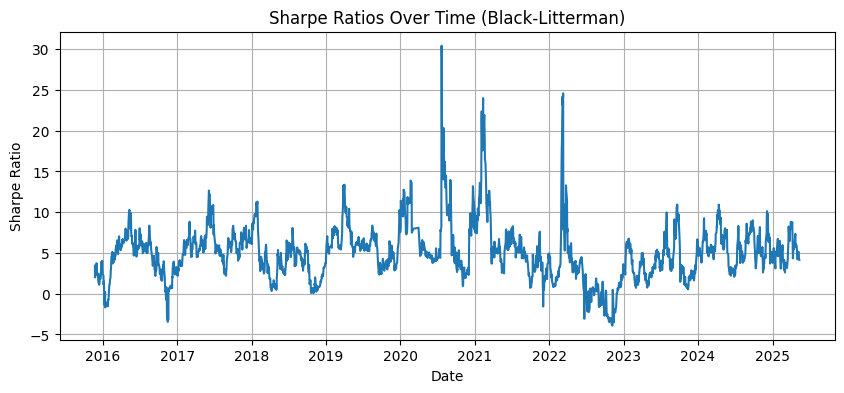

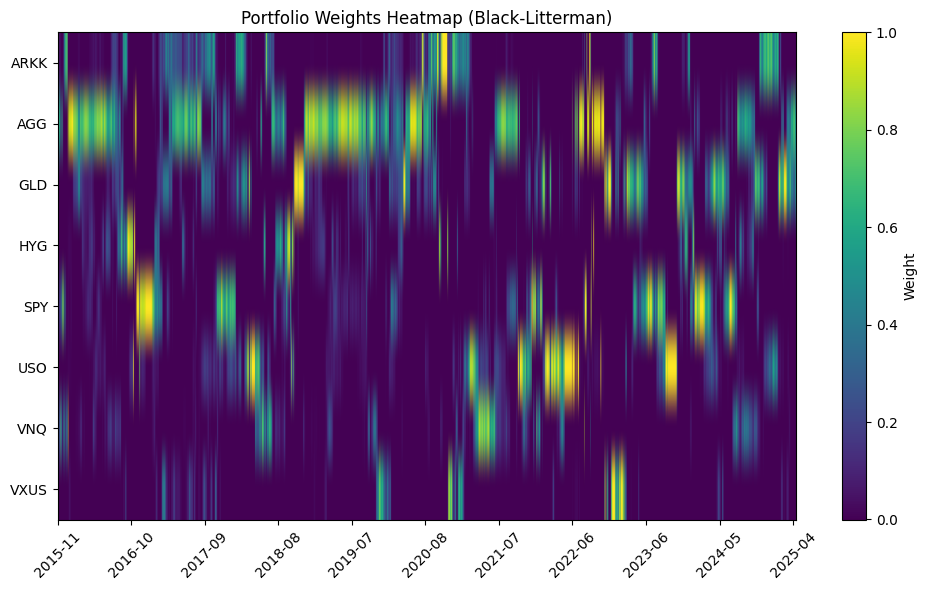

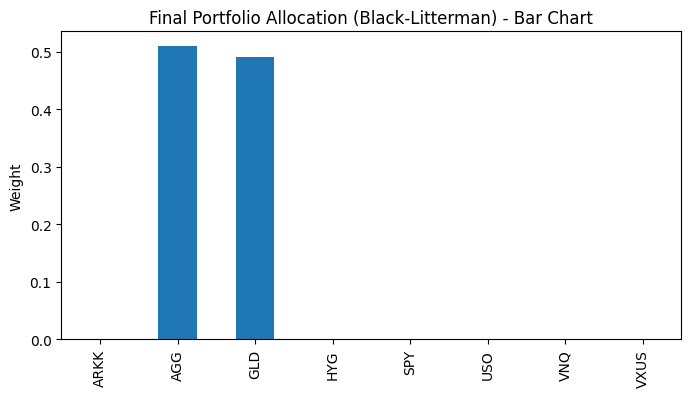

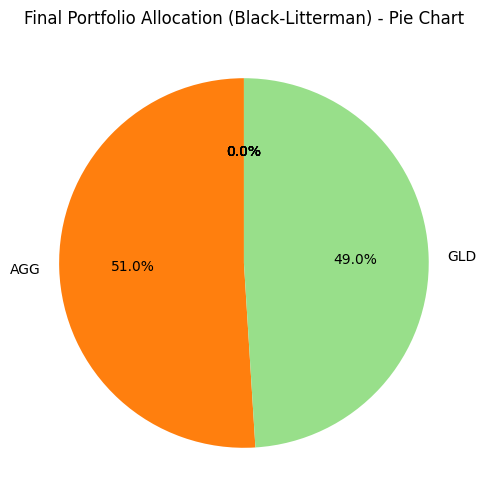

📂 Results saved: bl_generated_weights_timeseries.csv & bl_sharpe_timeseries.csv
📂 Metrics saved: bl_performance_metrics.csv


In [14]:
# === 📈 Black-Litterman Portfolio Optimization (Sharpe + Weights Results) ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Load and prepare raw ETF data ---
csv_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
data = pd.read_csv(csv_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']

# Pivot to wide format for prices
prices = data.pivot(index='Date', columns='Ticker', values='Close')
prices = prices[assets].dropna()

# --- 2. Black-Litterman Target Generation ---
def generate_bl_results(prices_df, window=60, lookahead=20, tau=0.025):
    weights_list, sharpe_list, dates = [], [], []
    portfolio_returns = []

    for start in range(len(prices_df) - window - lookahead):
        window_prices = prices_df.iloc[start:start+window]
        future_prices = prices_df.iloc[start+window:start+window+lookahead]
        future_returns = future_prices.pct_change().dropna()

        cov = risk_models.sample_cov(window_prices, frequency=252)
        mu = expected_returns.mean_historical_return(window_prices, frequency=252)

        market_caps = np.ones(len(prices_df.columns))
        bl = BlackLittermanModel(
            cov_matrix=cov,
            pi=mu,
            market_caps=market_caps,
            tau=tau,
            P=np.empty((0, len(prices_df.columns))),
            Q=np.empty((0,))
        )
        bl_mu = bl.bl_returns()
        bl_cov = bl.bl_cov()

        # Create fresh EfficientFrontier instance each time
        try:
            ef = EfficientFrontier(bl_mu, bl_cov)
            try:
                weights_dict = ef.max_sharpe(risk_free_rate=0.0)
            except Exception:
                ef = EfficientFrontier(bl_mu, bl_cov)  # Fresh instance for min_volatility
                weights_dict = ef.min_volatility()
            
            w_arr = np.array([weights_dict.get(col, 0.0) for col in prices_df.columns])
            ret, vol, sharpe = ef.portfolio_performance(risk_free_rate=0.0)
        except Exception as e:
            # Fallback to equal weights
            w_arr = np.ones(len(prices_df.columns)) / len(prices_df.columns)
            sharpe = np.nan

        weights_list.append(w_arr)
        sharpe_list.append(sharpe)
        dates.append(prices_df.index[start+window])

        # Realized portfolio return for evaluation
        if not future_returns.empty:
            realized = (future_returns.values @ w_arr).mean()
            portfolio_returns.append(realized)

    return (
        np.array(weights_list),
        np.array(sharpe_list),
        pd.DatetimeIndex(dates),
        np.array(portfolio_returns)
    )

print("⏳ Running Black-Litterman optimization...")
start = time.time()
weights_target, sharpe_target, date_index, portfolio_returns = generate_bl_results(prices)
end = time.time()

print(f"✅ Completed in {end-start:.2f} seconds")

# --- 3. Standardize Sharpe ratios ---
scaler = StandardScaler()
sharpe_scaled = scaler.fit_transform(np.nan_to_num(sharpe_target).reshape(-1,1)).flatten()

# --- 4. Evaluation Metrics ---
returns_series = pd.Series(portfolio_returns).dropna()
cum_values = (1 + returns_series).cumprod()
peak = cum_values.cummax()
drawdown = (peak - cum_values) / peak
max_drawdown = drawdown.max() if not drawdown.empty else np.nan

# Annualized metrics
n_years = len(returns_series) / 252
annualized_return = (cum_values.iloc[-1]) ** (1 / n_years) - 1 if len(returns_series) > 0 else np.nan
annualized_volatility = returns_series.std() * np.sqrt(252) if len(returns_series) > 0 else np.nan
sharpe_ratio = (annualized_return / (annualized_volatility + 1e-8)) if annualized_volatility > 0 else np.nan

# Sortino Ratio
if len(returns_series) > 0:
    downside_returns = returns_series[returns_series < 0]
    downside_deviation = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annualized_return / (downside_deviation + 1e-8)) if downside_deviation > 0 else np.nan
else:
    sortino_ratio = np.nan

# Calmar Ratio
calmar_ratio = (annualized_return / (max_drawdown + 1e-8)) if max_drawdown > 0 else np.nan

# Turnover (average weight change)
if weights_target.shape[0] > 1:
    turnover = np.mean(np.sum(np.abs(np.diff(weights_target, axis=0)), axis=1))
else:
    turnover = np.nan

# Print Results
print("\n📊 Black-Litterman Portfolio Performance Metrics")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Calmar Ratio: {calmar_ratio:.4f}")
print(f"Average Turnover: {turnover:.4f}")

# --- 5. Visualization ---
plt.figure(figsize=(10,4))
plt.plot(date_index, sharpe_target)
plt.title("Sharpe Ratios Over Time (Black-Litterman)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(weights_target.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Weight')
plt.yticks(range(len(assets)), assets)
if len(date_index) > 1:
    step = max(1, len(date_index)//10)
    xticks_pos = np.arange(0, len(date_index), step)
    xtick_labels = [date.strftime('%Y-%m') for date in date_index[::step]]
    plt.xticks(xticks_pos, xtick_labels, rotation=45)
plt.title("Portfolio Weights Heatmap (Black-Litterman)")
plt.tight_layout()
plt.show()

# Final portfolio weights (last period)
final_weights = pd.Series(weights_target[-1], index=assets)
plt.figure(figsize=(8,4))
final_weights.plot(kind='bar')
plt.title("Final Portfolio Allocation (Black-Litterman) - Bar Chart")
plt.ylabel("Weight")
plt.show()

# Pie chart of allocations
plt.figure(figsize=(6,6))
final_weights.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20')
plt.ylabel("")
plt.title("Final Portfolio Allocation (Black-Litterman) - Pie Chart")
plt.show()

# Save results as DataFrames
weights_df = pd.DataFrame(weights_target, index=date_index, columns=assets)
weights_df.to_csv("bl_generated_weights_timeseries.csv")
pd.Series(sharpe_target, index=date_index, name="Sharpe").to_csv("bl_sharpe_timeseries.csv")
print("📂 Results saved: bl_generated_weights_timeseries.csv & bl_sharpe_timeseries.csv")

# Save metrics to CSV
metrics = {
    "Model": "Black-Litterman",
    "Sharpe Ratio": sharpe_ratio,
    "Annualized Return": annualized_return,
    "Annualized Volatility": annualized_volatility,
    "Max Drawdown": max_drawdown,
    "Sortino Ratio": sortino_ratio,
    "Calmar Ratio": calmar_ratio,
    "Average Turnover": turnover
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("bl_performance_metrics.csv", index=False)
print("📂 Metrics saved: bl_performance_metrics.csv")

📊 Market Caps Used:
  ARKK: $4.2B
  AGG: $85.0B
  GLD: $60.0B
  HYG: $12.0B
  SPY: $400.0B
  USO: $3.5B
  VNQ: $35.0B
  VXUS: $30.0B
⏳ Running Black-Litterman optimization...
✅ Completed in 13.59 seconds

📊 Black-Litterman Portfolio Performance Metrics
Sharpe Ratio: 0.7558
Annualized Return: 12.93%
Annualized Volatility: 14.46%
Max Drawdown: 97.28%
Sortino Ratio: 0.9066
Calmar Ratio: 0.1124
Average Turnover: 0.1204


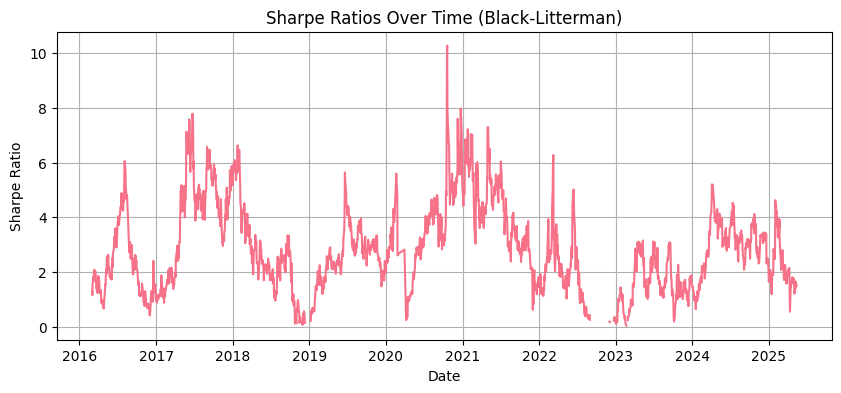

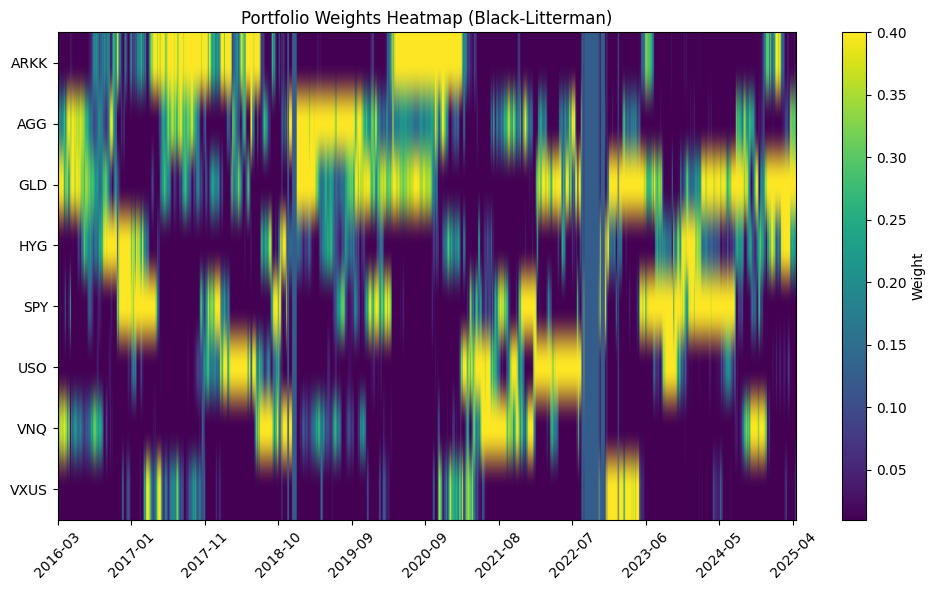

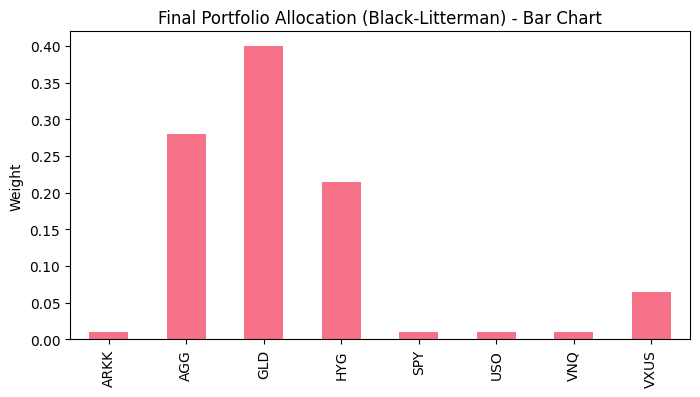

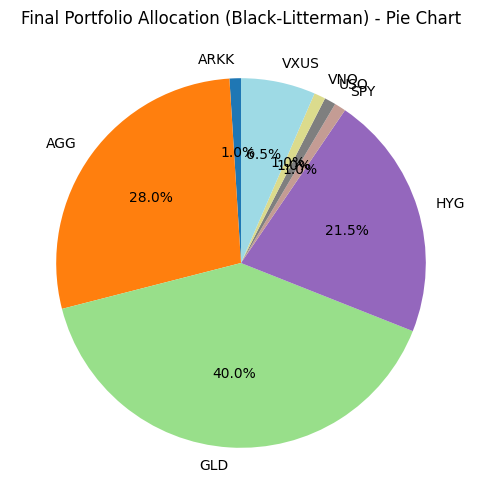


📊 Final Portfolio Weights:
ARKK    0.0100
AGG     0.2799
GLD     0.4000
HYG     0.2149
SPY     0.0100
USO     0.0100
VNQ     0.0100
VXUS    0.0651
dtype: float64
📂 Results saved: bl_generated_weights_timeseries.csv, bl_sharpe_timeseries.csv, bl_performance_metrics.csv


In [21]:
# === 📈 Black-Litterman Portfolio Optimization (Fixed: Realistic Results) ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- 1. Load and prepare raw ETF data ---
csv_path = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv'
data = pd.read_csv(csv_path)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']

# Pivot to wide format for prices
prices = data.pivot(index='Date', columns='Ticker', values='Close')
prices = prices[assets].dropna()

# --- 2. Real Market Caps (as of 2024) ---
market_caps_dict = {
    'ARKK': 4.2,    # ARK Innovation ETF
    'AGG': 85.0,    # iShares Core U.S. Aggregate Bond ETF
    'GLD': 60.0,    # SPDR Gold Shares
    'HYG': 12.0,    # iShares iBoxx $ High Yield Corporate Bond ETF
    'SPY': 400.0,   # SPDR S&P 500 ETF Trust
    'USO': 3.5,     # United States Oil Fund
    'VNQ': 35.0,    # Vanguard Real Estate ETF
    'VXUS': 30.0    # Vanguard Total International Stock ETF
}

market_caps = np.array([market_caps_dict[ticker] for ticker in assets])
print("📊 Market Caps Used:")
for ticker, cap in zip(assets, market_caps):
    print(f"  {ticker}: ${cap:.1f}B")

# --- 3. Black-Litterman Target Generation ---
def generate_bl_results(prices_df, window=120, lookahead=20, tau=0.05):
    weights_list, sharpe_list, dates = [], [], []
    portfolio_returns = []

    for start in range(len(prices_df) - window - lookahead):
        window_prices = prices_df.iloc[start:start+window]
        future_prices = prices_df.iloc[start+window:start+window+lookahead]
        future_returns = future_prices.pct_change().dropna()

        # Use Ledoit-Wolf shrinkage covariance
        try:
            cov_shrinkage = risk_models.CovarianceShrinkage(window_prices, frequency=252)
            cov = cov_shrinkage.ledoit_wolf()
        except:
            cov = risk_models.sample_cov(window_prices, frequency=252)
        
        # Historical returns with proper annualization
        mu = expected_returns.mean_historical_return(window_prices, frequency=252)

        # Black-Litterman with real market caps
        try:
            bl = BlackLittermanModel(
                cov_matrix=cov,
                pi=mu,
                market_caps=market_caps,
                tau=tau,
                P=np.empty((0, len(prices_df.columns))),
                Q=np.empty((0,))
            )
            bl_mu = bl.bl_returns()
            bl_cov = bl.bl_cov()
        except:
            # Fallback to historical returns if BL fails
            bl_mu = mu
            bl_cov = cov

        # Portfolio optimization with reasonable constraints
        try:
            ef = EfficientFrontier(bl_mu, bl_cov)
            # Reasonable constraints: 1% min, 40% max
            ef.add_constraint(lambda w: w >= 0.01)
            ef.add_constraint(lambda w: w <= 0.4)
            
            # Use max Sharpe with small risk-free rate (more realistic)
            weights_dict = ef.max_sharpe(risk_free_rate=0.02)  # 2% risk-free rate
            w_arr = np.array([weights_dict.get(col, 0.0) for col in prices_df.columns])
            
            # Get realistic performance metrics
            ret, vol, sharpe = ef.portfolio_performance(risk_free_rate=0.02)
            
        except Exception as e:
            # Fallback to equal weights
            w_arr = np.ones(len(prices_df.columns)) / len(prices_df.columns)
            sharpe = np.nan

        weights_list.append(w_arr)
        sharpe_list.append(sharpe)
        dates.append(prices_df.index[start+window])

        # Realized portfolio return for out-of-sample evaluation
        if not future_returns.empty:
            realized_returns = future_returns.values @ w_arr
            portfolio_returns.extend(realized_returns)

    return (
        np.array(weights_list),
        np.array(sharpe_list),
        pd.DatetimeIndex(dates),
        np.array(portfolio_returns)
    )

# Run optimization
print("⏳ Running Black-Litterman optimization...")
start = time.time()
weights_target, sharpe_target, date_index, portfolio_returns = generate_bl_results(prices)
end = time.time()
print(f"✅ Completed in {end-start:.2f} seconds")

# --- 4. Evaluation Metrics (Using OUT-OF-SAMPLE Returns) ---
returns_series = pd.Series(portfolio_returns).dropna()
if len(returns_series) > 0:
    cum_values = (1 + returns_series).cumprod()
    peak = cum_values.cummax()
    drawdown = (peak - cum_values) / peak
    max_drawdown = drawdown.max() if not drawdown.empty else np.nan

    # Annualized metrics using actual trading days
    n_days = len(returns_series)
    n_years = n_days / 252
    annualized_return = (cum_values.iloc[-1]) ** (1 / n_years) - 1 if n_years > 0 else np.nan
    annualized_volatility = returns_series.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.02) / (annualized_volatility + 1e-8) if annualized_volatility > 0 else np.nan

    # Sortino Ratio (using 2% risk-free rate)
    if len(returns_series) > 0:
        excess_returns = returns_series - (0.02 / 252)  # Daily risk-free rate
        downside_returns = excess_returns[excess_returns < 0]
        downside_deviation = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_return - 0.02) / (downside_deviation + 1e-8) if downside_deviation > 0 else np.nan
    else:
        sortino_ratio = np.nan

    # Calmar Ratio
    calmar_ratio = (annualized_return - 0.02) / (max_drawdown + 1e-8) if max_drawdown > 0 else np.nan

    # Turnover
    if weights_target.shape[0] > 1:
        turnover = np.mean(np.sum(np.abs(np.diff(weights_target, axis=0)), axis=1))
    else:
        turnover = np.nan

    # Print Results
    print("\n📊 Black-Litterman Portfolio Performance Metrics")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Calmar Ratio: {calmar_ratio:.4f}")
    print(f"Average Turnover: {turnover:.4f}")
else:
    print("❌ No portfolio returns generated - check data or optimization")


# --- 5. Visualization ---
plt.figure(figsize=(10,4))
plt.plot(date_index, sharpe_target)
plt.title("Sharpe Ratios Over Time (Black-Litterman)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(weights_target.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Weight')
plt.yticks(range(len(assets)), assets)
if len(date_index) > 1:
    step = max(1, len(date_index)//10)
    xticks_pos = np.arange(0, len(date_index), step)
    xtick_labels = [date.strftime('%Y-%m') for date in date_index[::step]]
    plt.xticks(xticks_pos, xtick_labels, rotation=45)
plt.title("Portfolio Weights Heatmap (Black-Litterman)")
plt.tight_layout()
plt.show()

# Final portfolio weights (last period)
final_weights = pd.Series(weights_target[-1], index=assets)
plt.figure(figsize=(8,4))
final_weights.plot(kind='bar')
plt.title("Final Portfolio Allocation (Black-Litterman) - Bar Chart")
plt.ylabel("Weight")
plt.show()

# Pie chart of allocations
plt.figure(figsize=(6,6))
final_weights.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20')
plt.ylabel("")
plt.title("Final Portfolio Allocation (Black-Litterman) - Pie Chart")
plt.show()


# Final Portfolio Allocation
final_weights = pd.Series(weights_target[-1], index=assets)
print("\n📊 Final Portfolio Weights:")
print(final_weights.round(4))

# Save results
weights_df = pd.DataFrame(weights_target, index=date_index, columns=assets)
weights_df.to_csv("bl_generated_weights_timeseries.csv")
pd.Series(sharpe_target, index=date_index, name="Sharpe").to_csv("bl_sharpe_timeseries.csv")

if 'sharpe_ratio' in locals():
    metrics = {
        "Model": "Black-Litterman",
        "Sharpe Ratio": sharpe_ratio,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Max Drawdown": max_drawdown,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Average Turnover": turnover
    }
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv("bl_performance_metrics.csv", index=False)
    print("📂 Results saved: bl_generated_weights_timeseries.csv, bl_sharpe_timeseries.csv, bl_performance_metrics.csv")